In [1]:
!pip install xgboost --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline


In [3]:
from google.colab import files
uploaded = files.upload()      # Choose Telco-Customer-Churn.csv

df = pd.read_csv("Telco-Customer-Churn.csv")
df.columns = df.columns.str.strip()     # remove hidden spaces
print("Columns:", df.columns.tolist())
df.head()


Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (3).csv
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(df.info())

# Convert TotalCharges to numeric & handle nulls
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop ID column & encode target
df = df.drop('customerID', axis=1)
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

print("Shape:", df.shape)
print("Churn distribution:\n", df['Churn'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


/tmp/ipython-input-2171070188.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [5]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target from numeric list
if 'Churn' in num_cols:
    num_cols.remove('Churn')

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Train shape: (5634, 19) Test shape: (1409, 19)


In [6]:
numeric = Pipeline([('scaler', StandardScaler())])
categorical = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer([
    ('num', numeric, num_cols),
    ('cat', categorical, cat_cols)
])


In [7]:
# Logistic Regression
lr = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])
lr.fit(X_train, y_train)

# Random Forest
rf = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)

# XGBoost
xgb = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:54:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   '...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [8]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    print(f"\n--- {name} ---")
    print(f"Accuracy:{acc:.3f}  Precision:{prec:.3f}  Recall:{rec:.3f}  ROC_AUC:{auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.imshow(confusion_matrix(y_test, y_pred), cmap='Blues')
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.legend(); plt.title(f"{name} – ROC Curve")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.show()
    return auc



--- Logistic Regression ---
Accuracy:0.806  Precision:0.657  Recall:0.559  ROC_AUC:0.842
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



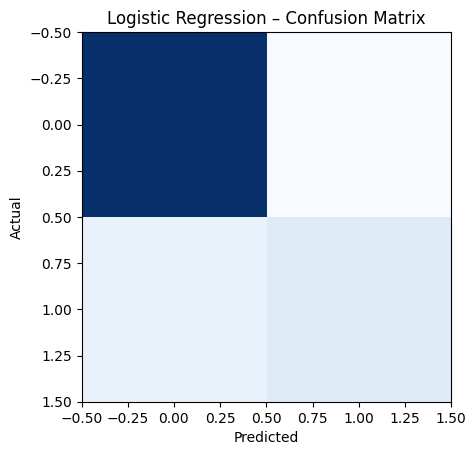

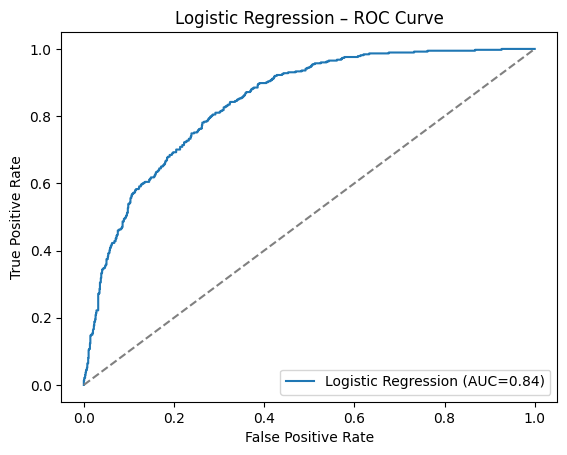


--- Random Forest ---
Accuracy:0.775  Precision:0.598  Recall:0.465  ROC_AUC:0.819
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.47      0.52       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409



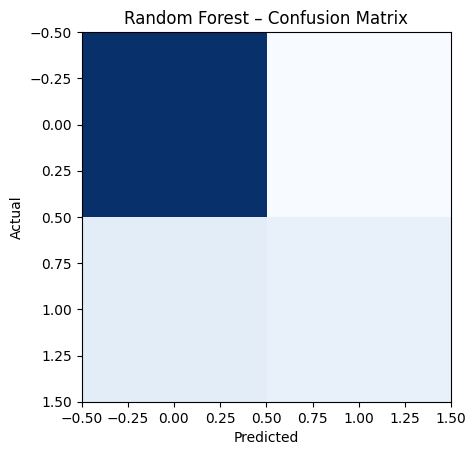

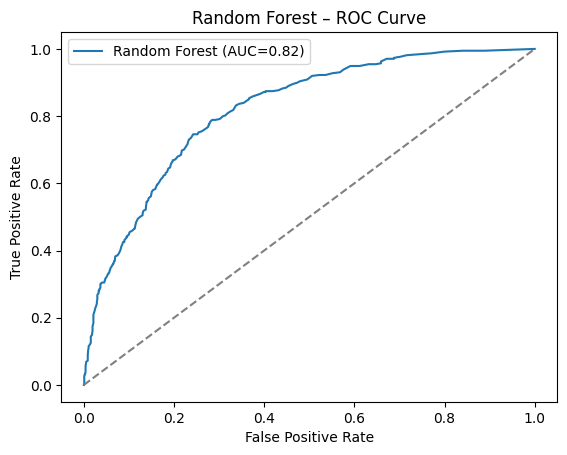


--- XGBoost ---
Accuracy:0.785  Precision:0.606  Recall:0.543  ROC_AUC:0.825
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.54      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409



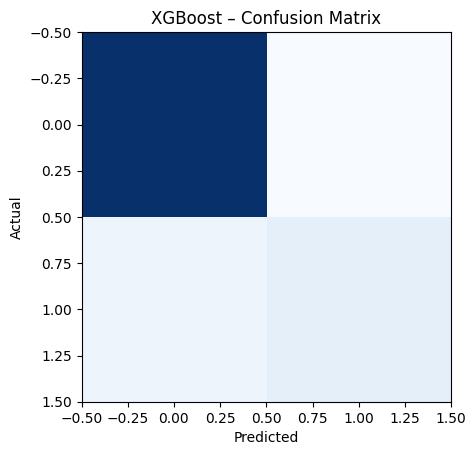

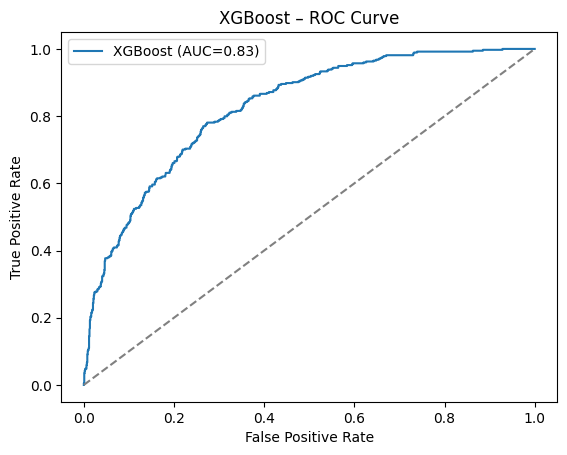


ROC-AUC Summary:
Logistic Regression: 0.8418739827946988
Random Forest: 0.8187036606473945
XGBoost: 0.825448862021752


In [9]:
auc_lr  = evaluate(lr,  X_test, y_test, "Logistic Regression")
auc_rf  = evaluate(rf,  X_test, y_test, "Random Forest")
auc_xgb = evaluate(xgb, X_test, y_test, "XGBoost")

print("\nROC-AUC Summary:")
print("Logistic Regression:", auc_lr)
print("Random Forest:", auc_rf)
print("XGBoost:", auc_xgb)


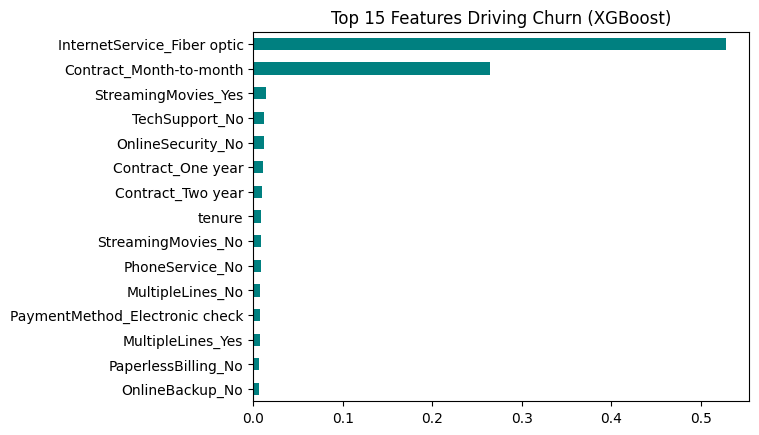

In [10]:
cat_features = xgb.named_steps['preprocess'].named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(cat_cols)
features = np.concatenate([num_cols, cat_features])

importances = xgb.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=features).sort_values(ascending=False)

fi[:15].plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("Top 15 Features Driving Churn (XGBoost)")
plt.show()


In [11]:
probs = xgb.predict_proba(X_test)[:,1]
result = X_test.copy()
result['churn_probability'] = probs
result.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn_probability
437,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,0.001239
2280,Female,1,No,No,8,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55,0.956376
2235,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.20,0.211823
4460,Male,0,Yes,No,18,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,78.20,1468.75,0.318882
3761,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),82.65,5919.35,0.000117


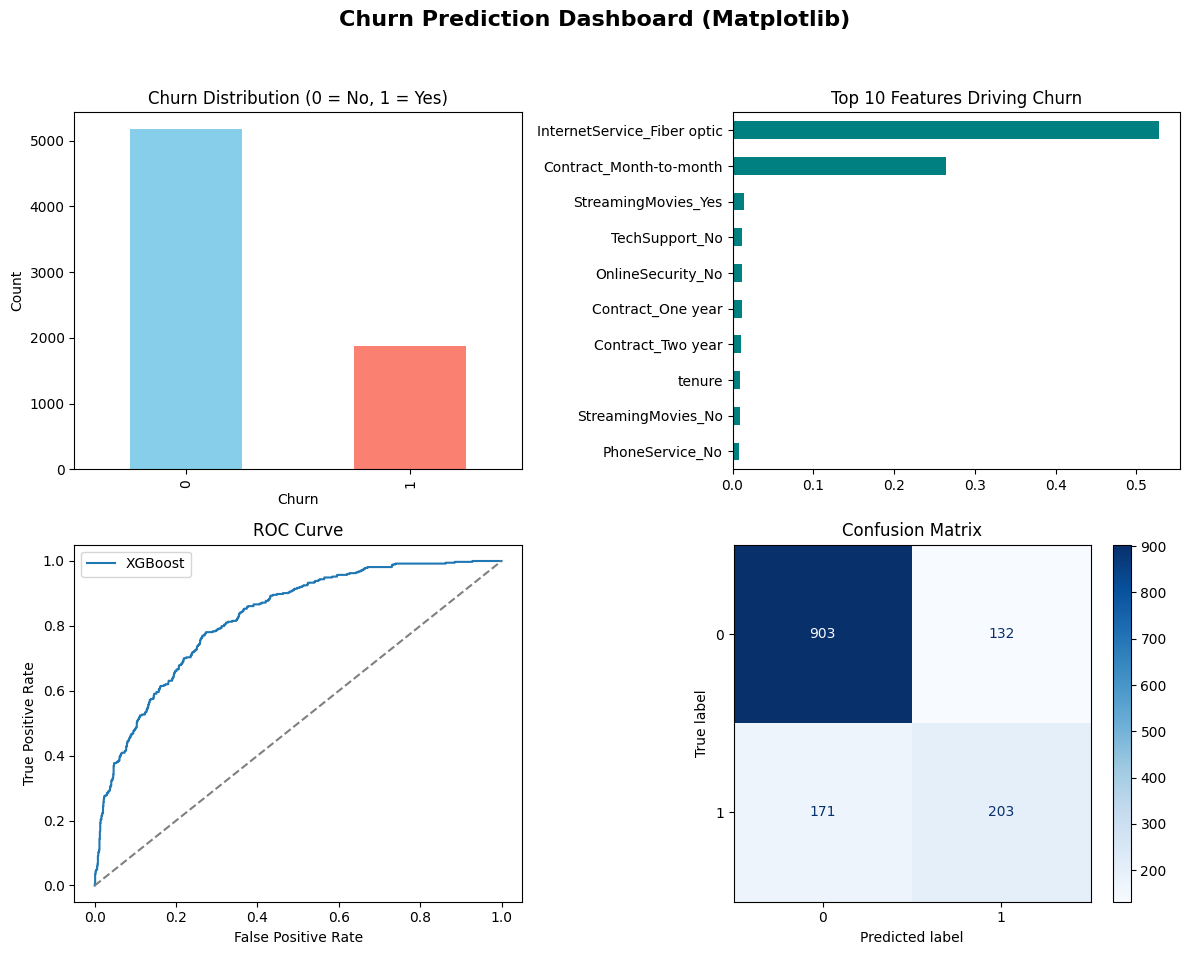

✅ Dashboard saved as Churn_Dashboard_Matplotlib.png


In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Churn Prediction Dashboard (Matplotlib)", fontsize=16, fontweight='bold')

# 1️⃣ Churn Distribution
df['Churn'].value_counts().plot(kind='bar', ax=axs[0,0], color=['skyblue','salmon'])
axs[0,0].set_title("Churn Distribution (0 = No, 1 = Yes)")
axs[0,0].set_xlabel("Churn"); axs[0,0].set_ylabel("Count")

# 2️⃣ Top 10 Feature Importances
fi[:10].plot(kind='barh', ax=axs[0,1], color='teal')
axs[0,1].set_title("Top 10 Features Driving Churn")
axs[0,1].invert_yaxis()

# 3️⃣ ROC Curve
y_prob = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
axs[1,0].plot(fpr, tpr, label='XGBoost')
axs[1,0].plot([0,1],[0,1],'--',color='gray')
axs[1,0].set_title("ROC Curve")
axs[1,0].set_xlabel("False Positive Rate")
axs[1,0].set_ylabel("True Positive Rate")
axs[1,0].legend()

# 4️⃣ Confusion Matrix
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, ax=axs[1,1], cmap='Blues')
axs[1,1].set_title("Confusion Matrix")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig("Churn_Dashboard_Matplotlib.png", dpi=300, bbox_inches='tight')
print("✅ Dashboard saved as Churn_Dashboard_Matplotlib.png")


## Step 12 — Optional Streamlit App (Interactive Demo)

Future Interns allows an optional bonus step: creating an **interactive UI** using Streamlit.  
The trained XGBoost model is saved as `churn_model.pkl`, and a separate file (`app.py`) can load it to predict churn for new customers.

> 💡 Note: Streamlit apps run locally or on Streamlit Cloud — not inside Colab.  
> Run this command in your local terminal or VS Code after downloading the files:  
> `streamlit run app.py`


In [14]:
# Save the trained XGBoost pipeline for the Streamlit app
import pickle
pickle.dump(xgb, open('churn_model.pkl', 'wb'))
print("✅ Model saved as churn_model.pkl – ready for Streamlit app integration.")


✅ Model saved as churn_model.pkl – ready for Streamlit app integration.


In [15]:
# Optional Streamlit App (app.py) – reference code
app_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import pickle

st.set_page_config(page_title="Churn Prediction System", page_icon="📊")

@st.cache_resource
def load_model():
    with open("churn_model.pkl", "rb") as file:
        model = pickle.load(file)
    return model

model = load_model()

st.title("📊 Customer Churn Prediction System")
st.write("Predict whether a customer is likely to churn based on their service details.")

st.sidebar.header("Enter Customer Details")

num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
cat_options = {
    'gender': ['Male', 'Female'],
    'Partner': ['Yes', 'No'],
    'Dependents': ['Yes', 'No'],
    'PhoneService': ['Yes', 'No'],
    'MultipleLines': ['Yes', 'No', 'No phone service'],
    'InternetService': ['DSL', 'Fiber optic', 'No'],
    'OnlineSecurity': ['Yes', 'No', 'No internet service'],
    'OnlineBackup': ['Yes', 'No', 'No internet service'],
    'DeviceProtection': ['Yes', 'No', 'No internet service'],
    'TechSupport': ['Yes', 'No', 'No internet service'],
    'StreamingTV': ['Yes', 'No', 'No internet service'],
    'StreamingMovies': ['Yes', 'No', 'No internet service'],
    'Contract': ['Month-to-month', 'One year', 'Two year'],
    'PaperlessBilling': ['Yes', 'No'],
    'PaymentMethod': ['Electronic check', 'Mailed check',
                      'Bank transfer (automatic)', 'Credit card (automatic)']
}

num_data = {}
for col in num_cols:
    num_data[col] = st.sidebar.number_input(f"{col}", min_value=0.0, step=1.0)

cat_data = {}
for col, options in cat_options.items():
    cat_data[col] = st.sidebar.selectbox(f"{col}", options=options)

input_data = {**num_data, **cat_data}
input_df = pd.DataFrame([input_data])

st.subheader("🔍 Input Summary")
st.dataframe(input_df)

if st.button("Predict Churn"):
    prediction = model.predict(input_df)
    probability = model.predict_proba(input_df)[:, 1][0]

    if prediction[0] == 1:
        st.error(f"⚠️ Customer is likely to **CHURN**.")
    else:
        st.success(f"✅ Customer is likely to **STAY**.")
    st.write(f"**Churn Probability:** {probability:.2f}")

st.markdown("---")
st.caption("Developed by Vignesh L V | Future Interns – Machine Learning Task 2")
'''

print(app_code)



import streamlit as st
import pandas as pd
import numpy as np
import pickle

st.set_page_config(page_title="Churn Prediction System", page_icon="📊")

@st.cache_resource
def load_model():
    with open("churn_model.pkl", "rb") as file:
        model = pickle.load(file)
    return model

model = load_model()

st.title("📊 Customer Churn Prediction System")
st.write("Predict whether a customer is likely to churn based on their service details.")

st.sidebar.header("Enter Customer Details")

num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
cat_options = {
    'gender': ['Male', 'Female'],
    'Partner': ['Yes', 'No'],
    'Dependents': ['Yes', 'No'],
    'PhoneService': ['Yes', 'No'],
    'MultipleLines': ['Yes', 'No', 'No phone service'],
    'InternetService': ['DSL', 'Fiber optic', 'No'],
    'OnlineSecurity': ['Yes', 'No', 'No internet service'],
    'OnlineBackup': ['Yes', 'No', 'No internet service'],
    'DeviceProtection': ['Yes', 'No', 'No internet service'